In [4]:
import numpy as np
from numba import jit

class Household:
    
    """
    this class takes the parameters that define a household asset accumulation problem 
    and compute the corresponding reward and transition matrices R and Q required to 
    generate an instance of DiscreteDP, and thereby solve for the optimal policy
    
    comments on indexing: we need to enumerate the state space S as a sequence
    S={0,..., n}. to this end, (a_i, z_i) index pairs are mapped to s_i indeces according
    to the rule
    
        s_i =a_i *z_size +z_i
    
    to invert this map, use
    
        a_i =s_i // z_size (integer division)
        z_i =s_i % z_size
        
    """
    
    def __init__(self,
                r=0.01, #interest rate
                w=1.0, #wages
                beta=0.96, #discount factor
                a_min=1e-10,
                Pi=[[0.9, 0.1],[0.1, 0.9]], #Markov chain
                z_vals=[0.1, 1.0], #exogenous states
                a_max=18,
                a_size=200):
        
        #store values, set up grids over a and z
        self.r, self.w, self.beta=r, w, beta
        self.a_min, self.a_max, self.a_size=a_min, a_max, a_size
        
        self.Pi=np.asarray(Pi)
        self.z_vals=np.asarray(z_vals)
        self.z_size=len(z_vals)
        
        self.a_vals=np.linspace(a_min, a_max, a_size)
        self.n=a_size * self.z_size
        
        #build the array Q
        self.Q=np.zeros((self.n, a_size, self.n))
        self.build_Q()
        
        #build the array R
        self.R=np.empty((self.n, a_size))
        self.build_R()
        
    def set_prices(self, r, w):
        """
        use this method to rest prices. calling the method will trigger a 
        re-build of R
        """
        self.r, self.w=r, w
        self.build_R()
        
    def build_Q(self):
        populate_Q(self.Q, self.a_size, self.z_size, self.Pi)
        
    def build_R(self):
        self.R.fill(-np.inf)
        populate_R(self.R, self.a_size, self.z_size, self.a_vals, self.z_vals, self.r, self.w)
        
    #do the hard work using JIT-ed functions
    
@jit(nopython=True)
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w):
    n=a_size * z_size
    for s_i in range(n):
        a_i =s_i // z_size
        z_i =s_i % z_size
        a =a_vals[a_i]
        z =z_vals[z_i]
        for new_a_i in range(a_size):
            a_new =a_vals[new_a_i]
            c =w * z +(1+r)*a -a_new
            if c>0:
                R[s_i, new_a_i]=np.log(c) #utility

@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Pi):
    n=a_size * z_size
    for s_i in range(n):
        z_i =s_i % z_size
        for a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, a_i, a_i*z_size+next_z_i]=Pi[z_i, next_z_i]

@jit(nopython=True)
def asset_marginal(s_probs, a_size, z_size):
    a_probs=np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            a_probs[a_i]+=s_probs[a_i*z_size+z_i]
    return a_probs

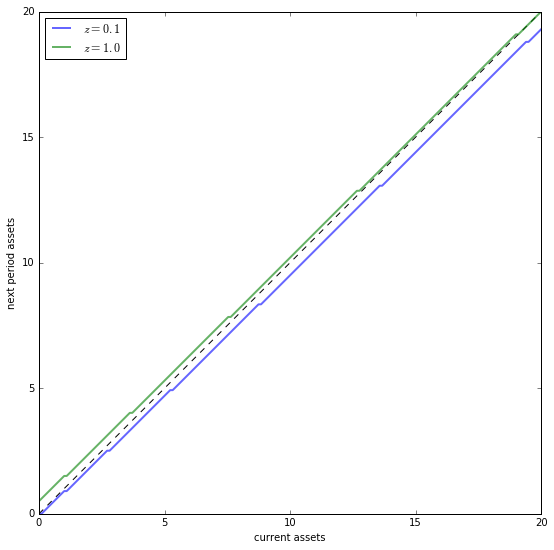

In [5]:
%matplotlib inline
import quantecon as qe
import matplotlib.pyplot as plt
from quantecon.markov import DiscreteDP

#example prices
r=0.03
w=0.956

#create an instance of Household
am=Household(a_max=20, r=r, w=w)

#use the instance to build a discrete dynamic program
am_ddp=DiscreteDP(am.R, am.Q, am.beta)

#solve using policy function iteration
results=am_ddp.solve(method='policy_iteration')

# Simplify names
z_size, a_size = am.z_size, am.a_size
z_vals, a_vals = am.z_vals, am.a_vals
n = a_size * z_size

# Get all optimal actions across the set of a indices with z fixed in each row
a_star = np.empty((z_size, a_size))
for s_i in range(n):
    a_i = s_i // z_size
    z_i = s_i % z_size
    a_star[z_i, a_i] = a_vals[results.sigma[s_i]]

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_vals, a_vals, 'k--')# 45 degrees
for i in range(z_size):
    lb = r'$z = {}$'.format(z_vals[i], '.2f')
    ax.plot(a_vals, a_star[i, :], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')

plt.show()

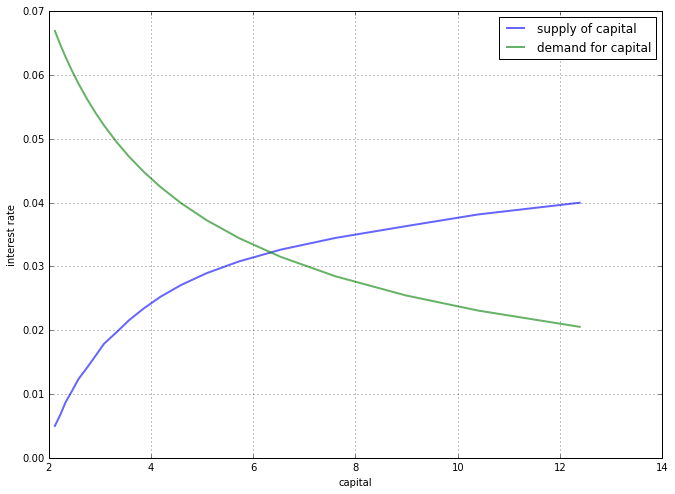

In [6]:
A=2.5
N=0.05
alpha=0.33
beta=0.96

def r_to_w(r):
    return A * (1-alpha) * (alpha / (1+r)) **(alpha /(1-alpha))

def rd(K):
    """
    inverse demand curve for capital.
    the interest rate associated with a given demand for capital K
    """
    return A * alpha * (N/K)**(1-alpha)

def price_to_capital_stock(am, r):
    """
    map prices to the induced level of capital stock
    
    parameters:
    ------
    
    am: Household
        an instance of an aiyagari_household.Household
    r: float
        the interest rate
    
    """
    w=r_to_w(r)
    am.set_prices(r, w)
    aiyagari_ddp=DiscreteDP(am.R, am.Q, beta)
    #compute the optimal policy
    results=aiyagari_ddp.solve(method='policy_iteration')
    #compute the stationary distribution
    stationary_probs=results.mc.stationary_distributions[0]
    #extract the marginal distribution for assets
    asset_probs=asset_marginal(stationary_probs, am.a_size, am.z_size)
    #return K
    return np.sum(asset_probs * am.a_vals)

#create an instance of Household
am=Household(a_max=20)

#use the instance to build a discrete dynamic program
am_ddp =DiscreteDP(am.R, am.Q, am.beta)

#create a grid of r values at which to compute demand and supply of capital
num_points=20
r_vals=np.linspace(0.005, 0.04, num_points)

#compute supply of capital
k_vals=np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i]=price_to_capital_stock(am, r)
    
#plot against demand for capital by firms
fig, ax=plt.subplots(figsize=(11, 8))
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')

plt.show()